# Integrated Hydrology

This is a series of problems to test and demonstrate the integrated hydrology components of ATS.  Integrated hydrology consists of Richards equation in the subsurface coupled to a diffusion wave approximation on the surface system.  Coupling is done through assuming continuous pressure and flux across the surface-subsurface interface.

Tests demonstrate a 1D column (showing dry-to-wet and wet-to-dry transitions), a 2D "open book" problem (showing that water flows down hill) and a typical 2D "hillslope" problem comparable to the Sulis et al (WRR) benchmark problems.

Author: Ethan Coon

In [1]:
%matplotlib inline

In [2]:
import sys,os
sys.path.append(os.path.join(os.environ['ATS_SRC_DIR'],'tools', 'utils'))
sys.path.append(os.path.join(os.environ['ATS_SRC_DIR'],'docs', 'documentation', 'source', 'ats_demos'))

import ats_xdmf
import plot_column_data

import colors
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colorbar
import pandas
import run_demos

## Example 1: 1D infiltration

In the first example, we rain on a column for half a day, then turn off the rain.  A continuous, constant baseflow is applied as a sink at the bottom of the column.  Initially the column is partially saturated.  As rainfall > baseflow, the column saturates and ponded water expresses on the surface.  After rainfall stops, baseflow takes the water table below the surface again. 

This demonstrates the dry-to-wet and wet-to-dry transitions.

In [3]:
# run the simulation
run_demos.run_demo_local('column')

In [4]:
# load the ATS solution
directory = "./column.demo"
vis = ats_xdmf.VisFile(directory, output_time_unit='d')
vis.loadMesh(columnar=True)

vis_surf = ats_xdmf.VisFile(directory, domain='surface', output_time_unit='d')
vis.loadMesh(columnar=True)


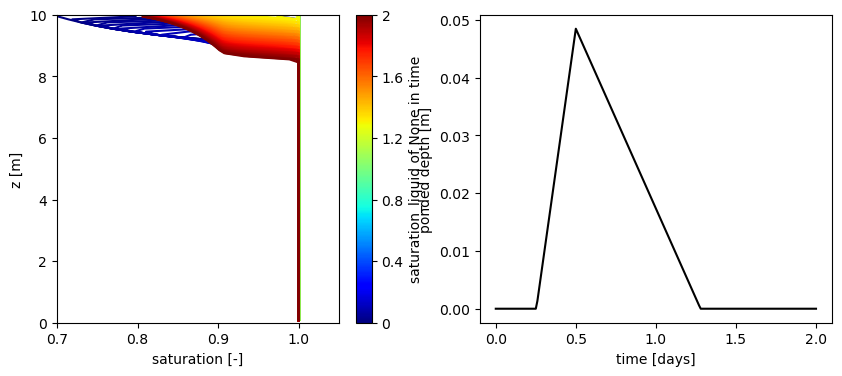

In [5]:
# plot the solution
fig, axs = plt.subplots(1,2, figsize=(10,4))

plot_column_data.plot_subsurface(vis, ['saturation_liquid',], axs[0], None, cmap='jet')
axs[0].set_xlabel('saturation [-]')
axs[0].set_ylabel('z [m]')
axs[0].set_xlim(0.7,1.05)
axs[0].set_ylim(0,10)

plot_column_data.plot_surface(vis_surf, ['ponded_depth',], axs[1], 'ponded depth [m]','k')
axs[1].set_xlabel("time [days]")
axs[1].set_ylabel("ponded depth [m]")

plt.show()

## Example 2: IH-MIP Runoff Generation

These are lowest-resolution runs (80m in x, 0.2m in z) from the Integrated Hydrology MIP #1 paper, Maxwell et al WRR, 2013, and demonstrate saturation-limited and infiltration-limited runs of integrated hydrology.  Note there is an error in that paper -- units of alpha in the van Genuchten curve are [1/m], not [1/cm].

In [6]:
# run the simulation
run_demos.run_demo_local(['saturation_limited1', 'saturation_limited2', 'infiltration_limited1', 'infiltration_limited2'])

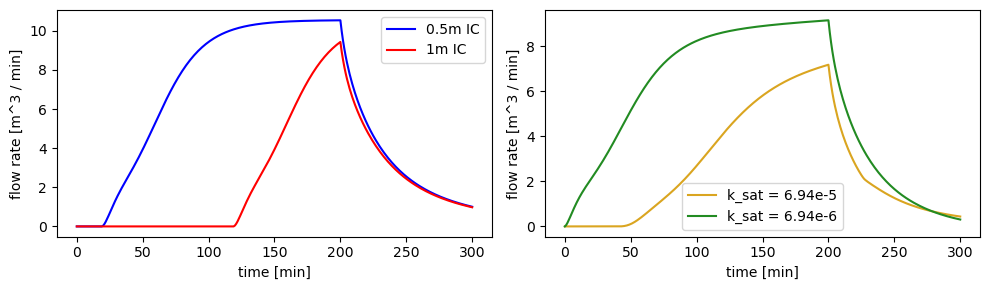

In [7]:
# plot the hydrograph
d1 = 'saturation_limited1.demo'
d2 = 'saturation_limited2.demo'
d3 = 'infiltration_limited1.demo'
d4 = 'infiltration_limited2.demo'
fig, axs2 = plt.subplots(1,2, figsize=(10,3))

dat = pandas.read_csv(os.path.join(d1, 'surface_outlet_flux.dat'), comment='#')
axs2[0].plot(dat['time [s]'][:]/60.0, dat['surface outlet flux'][:]/55389.0*60., 'b', label='0.5m IC')
dat2 = pandas.read_csv(os.path.join(d2, 'surface_outlet_flux.dat'), comment='#')
axs2[0].plot(dat2['time [s]'][:]/60.0, dat2['surface outlet flux'][:]/55389.0*60., 'r', label='1m IC')
axs2[0].legend()
axs2[0].set_xlabel('time [min]')
axs2[0].set_ylabel('flow rate [m^3 / min]')

dat3 = pandas.read_csv(os.path.join(d3, 'surface_outlet_flux.dat'), comment='#')
axs2[1].plot(dat3['time [s]'][:]/60.0, dat3['surface outlet flux'][:]/55389.0*60., 'goldenrod', label='k_sat = 6.94e-5')
dat4 = pandas.read_csv(os.path.join(d4, 'surface_outlet_flux.dat'), comment='#')
axs2[1].plot(dat4['time [s]'][:]/60.0, dat4['surface outlet flux'][:]/55389.0*60., 'forestgreen', label='k_sat = 6.94e-6')
axs2[1].legend()
axs2[1].set_xlabel('time [min]')
axs2[1].set_ylabel('flow rate [m^3 / min]')

plt.tight_layout()
plt.show()

## Example 3: Sulis et al comparison

These are lowest-resolution runs (80m in x, 0.2m in z) from the predecessor to that paper, Sulis et al 2010, which investigated the comparison across a variety of slopes as well. These demonstrate saturation-limited and infiltration-limited runs of integrated hydrology.

In [8]:
# run the demos.  Note this should only run two runs if you have previously run the last set of demos.
run_demos.run_demo_local(['saturation_limited1', 'saturation_limited3', 'infiltration_limited1', 'infiltration_limited3'])

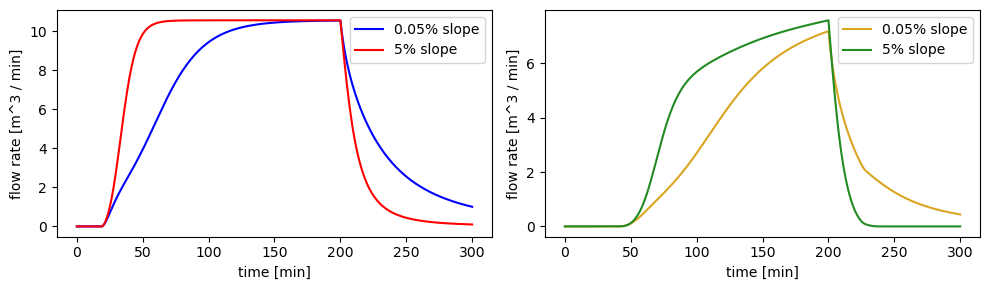

In [9]:
# plot the hydrograph
d1 = 'saturation_limited1.demo'
d2 = 'saturation_limited3.demo'
d3 = 'infiltration_limited1.demo'
d4 = 'infiltration_limited3.demo'
fig, axs3 = plt.subplots(1,2, figsize=(10,3))

n_liq = 55347.3783

dat = pandas.read_csv(os.path.join(d1, 'surface_outlet_flux.dat'), comment='#')
axs3[0].plot(dat['time [s]'][:]/60.0, dat['surface outlet flux'][:]/n_liq*60., 'b', label='0.05% slope')
dat2 = pandas.read_csv(os.path.join(d2, 'surface_outlet_flux.dat'), comment='#')
axs3[0].plot(dat2['time [s]'][:]/60.0, dat2['surface outlet flux'][:]/n_liq*60., 'r', label='5% slope')
axs3[0].set_xlabel('time [min]')
axs3[0].set_ylabel('flow rate [m^3 / min]')
axs3[0].legend()

dat3 = pandas.read_csv(os.path.join(d3, 'surface_outlet_flux.dat'), comment='#')
axs3[1].plot(dat3['time [s]'][:]/60.0, dat3['surface outlet flux'][:]/n_liq*60., 'goldenrod', label='0.05% slope')
dat4 = pandas.read_csv(os.path.join(d4, 'surface_outlet_flux.dat'), comment='#')
axs3[1].plot(dat4['time [s]'][:]/60.0, dat4['surface outlet flux'][:]/n_liq*60., 'forestgreen', label='5% slope')
axs3[1].legend()
axs3[1].set_xlabel('time [min]')
axs3[1].set_ylabel('flow rate [m^3 / min]')

plt.tight_layout()
plt.show()

## Example 4: V-catchment transect

In the next example, we rain on a transect of a V-catchment in 2D, allowing the water to pond.  This simply demonstrates that water runs downhill (in a coupled environment) and pools on the surface.  The plots show saturation (in colors) in the subsurface and the ponded depth (a line above the catchment).  

At time zero, a water table is established.  Infiltration occurs through the 30 hour plot.  By 60 hours, the domain is saturated and water is ponding on the surface.

In [10]:
# run the demo
run_demos.run_demo_local('transect')

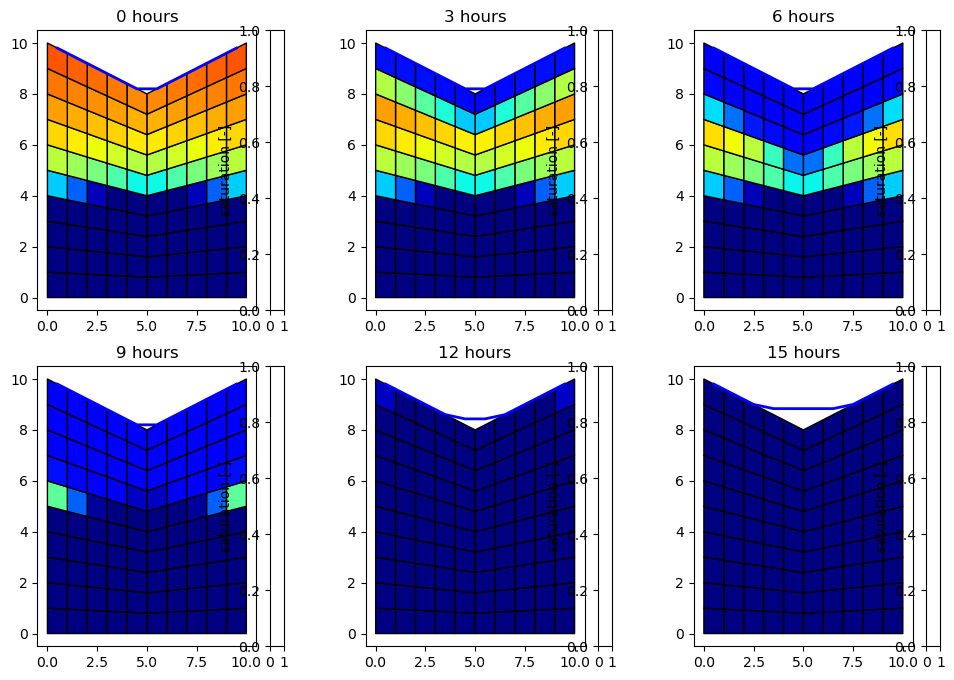

In [11]:
# plot the saturation at a few times
directory = "transect.demo"

vis = ats_xdmf.VisFile(directory, output_time_unit='d')
vis.filterIndices(range(0,21,4))
vis.loadMeshPolygons()

vis_surf = ats_xdmf.VisFile(directory, domain='surface', output_time_unit='d')
vis_surf.filterIndices(range(0,21,4))
vis_surf.loadMesh(order=['x','z'])

fig, axs = plt.subplots(2,3,figsize=(12,8))

def plot(i, ax):
    cax = colorbar.make_axes(ax, 'right')[0]
    cax.set_ylabel("saturation [-]")

    sat = vis.get("saturation_liquid", vis.cycles[i])
    poly = vis.getMeshPolygons(cmap='jet_r', linewidth=1)
    poly.set_array(sat)
    poly.set_clim(0.4,1)
    ax.add_collection(poly)

    elev = vis_surf.get('surface-elevation', vis.cycles[i])
    pd = vis_surf.get('surface-ponded_depth', vis.cycles[i])

    ax.plot(vis_surf.centroids[:,0], elev+pd, 'b', linewidth=2)
    ax.set_title(f"{3*i} hours")
    
plot(0, axs[0,0])
plot(1, axs[0,1])
plot(2, axs[0,2])
plot(3, axs[1,0])
plot(4, axs[1,1])
plot(5, axs[1,2])

## Example 5: Superslab problem

The last demo is based off of the superslab problem from Kollet et all 2018 IH-MIP Benchmark 2 paper.  The goal of this demo is to show how to extend the above integrated hydrology problems into cases with multiple materials or soil types.

Note this run is a bit bigger (10k grid cells) and is natively run on 2 cores.  It takes about 20 minutes to run on a laptop with debug code.

In [12]:
# run the demo
run_demos.run_demo_local('superslab')

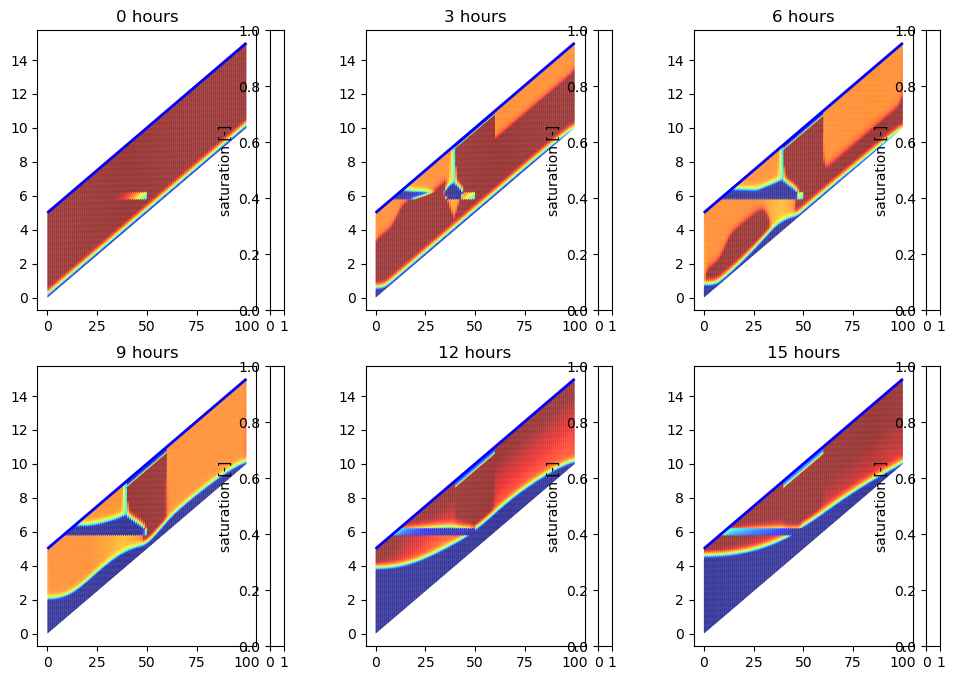

In [13]:
# plot the saturation at a few times
directory = "superslab.demo"

vis = ats_xdmf.VisFile(directory, output_time_unit='d')
vis.filterIndices(list(range(0,11,2)))
vis.loadMeshPolygons()

vis_surf = ats_xdmf.VisFile(directory, domain='surface', output_time_unit='d')
vis_surf.filterIndices(list(range(0,11,2)))
vis_surf.loadMesh(order=['x','z'])

fig, axs = plt.subplots(2,3,figsize=(12,8))

def plot(i, ax):
    cax = colorbar.make_axes(ax, 'right')[0]
    cax.set_ylabel("saturation [-]")

    sat = vis.get("saturation_liquid", vis.cycles[i])
    poly = vis.getMeshPolygons(cmap='jet_r', linewidth=0)
    poly.set_array(sat)
    poly.set_clim(0.4,1)
    ax.add_collection(poly)

    elev = vis_surf.get('surface-elevation', vis.cycles[i])
    pd = vis_surf.get('surface-ponded_depth', vis.cycles[i])

    ax.plot(vis_surf.centroids[:,0], elev+pd, 'b', linewidth=2)
    ax.set_title(f"{3*i} hours")
    
plot(0, axs[0,0])
plot(1, axs[0,1])
plot(2, axs[0,2])
plot(3, axs[1,0])
plot(4, axs[1,1])
plot(5, axs[1,2])


